# Vehicle Detection Project

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler

In [ ]:
# images are divided up into vehicles and non-vehicles
cars = glob.glob('training_set/vehicles/**/*.png')
notcars = glob.glob('training_set/non-vehicles/**/*.png')

In [ ]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


In [ ]:
pix_per_cell = 8
cell_per_block = 2
orient = 6

hog_images = []
hog_features = []
img_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

for i in range(6,13,1):
    orient = i
    features, hog_image = hog(img_gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)    
    hog_features.append(features)
    hog_images.append(hog_image)
    

pos = 241
#plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(18,8))
plt.subplot(pos)
plt.imshow(car_image)
plt.title('Car Image')

pos += 1
orient = 6
cnt_features = 0
for hog_image in hog_images:
    plt.subplot(pos)
    plt.imshow(hog_image, cmap='gray')
    
    # unroll feature vector
    # NOTE: feature can be directly unrolled by the hog() function. Set feature_vector=True
    feature_vec = hog_features[cnt_features].ravel()
    plt.title('HOG Image ' + str(orient) + ' ' + str(len(feature_vec)))
    pos += 1
    orient += 1
    cnt_features += 1

## Vehicle detector
The following cells implement one or more vehicle classifiers. Therefore, we use the sklearn library which provides different classifiers like SVMs or Decision Trees as well as tools for different pre-processing task like data splitting, shuffling and so on.

These are the steps that will be carried out:
- Create a dataset.
- Split data into a training and a testing set.
- Train a classifier. Here, I start with an SVM
- Test classifier
- Tune Hyperparameters if needed

## Create the dataset and store it as a csv file

In [ ]:
# Our data set consists of vehicle and non-vehicle images. We iterate over all images, apply HOG to each image and store
# HOG features with a corresponding label, 1 for car and 0 for non-car, as feature row in a pandas data frame. Finally,
# we write the data frame in a file in csv format.
import pandas as pd

def calc_number_of_features(pix_per_cell, cells_per_block, orient, imgsize=64):
    """
    Calculates the number of HOG features.
    """  
    
    blocks = imgsize // pix_per_cell
    
    return (blocks - (cells_per_block - 1)) * (blocks - (cells_per_block - 1)) *  cells_per_block * cells_per_block *  orient

def create_header(num_features, pix_per_cell, cells_per_block, orient):
    """
    Creates the header for our dataset.
    """
    header_entries = ['hog_' + str(pix_per_cell) + '_' + str(cells_per_block) + '_' + str(orient) + '_' + str(i) for i in range(num_features)]    
    header_entries.insert(0,'imagename')
    header_entries.append('label')
    
    return header_entries
    
def create_feature_row(imgname, isVehicle, pix_per_cell, cells_per_block, orient):
    """
    Computes HOG features and returns a feature row. 
    First, the image is grayscaled and the HOG function is called.
    The last entry is the label and the remaining ones describe the 
    compute HOG feature vector. The number of feature items depends on the block 
    and cell size and the number of orientations.
    """
    img = mpimg.imread(imgname)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    features = hog(img_gray, 
                   orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cells_per_block, cells_per_block),
                   visualise=False, 
                   feature_vector=True)
    
    feature_list = features.tolist()
    feature_list.insert(0, imgname)
    feature_list.append(1 if isVehicle else 0)
    
    return feature_list


In [ ]:
pix_per_cell = 8
cell_per_block = 2
orient = 6

num_features = calc_number_of_features(pix_per_cell, cell_per_block, orient)
header = create_header(num_features, pix_per_cell, cell_per_block, orient)

print(num_features, len(header))

feature_rows = []

# iterate over each car image
for car in cars:
    row = create_feature_row(car, True, cell_per_block, pix_per_cell, orient)
    feature_rows.append(row)
    
# iterate over each non-car image
for notcar in notcars:
    row = create_feature_row(notcar, False, cell_per_block, pix_per_cell, orient)
    feature_rows.append(row)
    
print(len(feature_rows[0]), len(header))
assert(len(feature_rows[0]) == len(header))

df = pd.DataFrame(feature_rows, columns=header)
df.to_csv('dataset_8_2_6.csv', sep='\t')

In [ ]:
df.head(5)

## Create a training and a test set
- Read dataset into a dataframe
- Remove first column which contains the path to the image
- Split dataset into features and labels
- Shuffle the dataset
- Split dataset into a training- and test set.

In [ ]:
dataset = pd.read_csv('dataset_8_2_6.csv', sep='\t')
dataset.drop(dataset.columns[[0]], axis=1, inplace=True)
popped = dataset.pop('imagename')

In [ ]:
len(dataset.columns)

## Train an SVM Classifier

In [2]:
import itertools
from sklearn import metrics
from sklearn import svm
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [ ]:
shuffled_dataset = shuffle(dataset)
num_features = len(dataset.columns)
X = shuffled_dataset.ix[:,0:num_features-1]
y = shuffled_dataset.ix[:,num_features-1:num_features]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
classifier = svm.SVC()
classifier.fit(X_train, y_train.values.ravel())

In [ ]:
# store the model
joblib.dump(classifier, 'svm_model.pkl') 

In [ ]:
# taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def calc_metrics(y_test, y_pred):    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1score = metrics.f1_score(y_test, y_pred)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, recall, f1score, cnf_matrix

In [ ]:
# Evaluate model
y_pred = classifier.predict(X_test)

accuracy, precision, recall, f1score, cnf_matrix = calc_metrics(y_test, y_pred)

print('Accuracy ', accuracy)
print('Precision ', precision)
print('Recall ', recall)
print('F1 score ', f1score)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NoCar', 'Car'], title='Confusion matrix, without normalization')

### Hyperparameter Tuning
In the following cell I try to tune SVM's hyperparameters by using doing a GridSearch

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train.values.ravel())

In [ ]:
# Evaluate the tuned model
y_pred = clf.predict(X_test)

accuracy, precision, recall, f1score, cnf_matrix = calc_metrics(y_test, y_pred)

print('Accuracy ', accuracy)
print('Precision ', precision)
print('Recall ', recall)
print('F1 score ', f1score)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NoCar', 'Car'], title='Confusion matrix, without normalization')

In [ ]:
# store tuned model
joblib.dump(clf, 'svm_tuned_model.pkl') 

In [ ]:
# show best parameters
clf.best_params_

In [38]:
# load model
clf = joblib.load('svm_dataset_8_2_9_3_32.pkl')

## Train a Descision Tree

## Sliding Window Implementation

In [4]:
# Contains functions for feature extraction: HOG, color and spatial
import dataset_generator as dg

In [34]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, classifier, scale=1, ystart=400, ystop=656, orient=6, pix_per_cell=8, cells_per_block=2, colors=[(0,255,0), (255,0,0)]):
    
    draw_img = np.copy(img)    
    img_tmp = img[ystart:ystop,:,:]
    img_tosearch = img[ystart:ystop,:,:]
    
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    img_converted = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    # Define blocks and steps as above
    nxblocks = (img_converted.shape[1] // pix_per_cell) - cells_per_block + 1
    nyblocks = (img_converted.shape[0] // pix_per_cell) - cells_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cells_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
            
    # contains all boxes which may contain a vehicle
    boxes = []
    
    positive = 0
    negative = 0
    
    features = []
    
    test_images = glob.glob('output_images/*.jpg')
    test_images.sort(key=os.path.getmtime)
    counter = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
                        
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            img = mpimg.imread(test_images[counter])
            subimg = dg.to_colorspace(img, 'YCrCb')
            counter += 1
            
            #subimg = img_converted[ytop:ytop+window, xleft:xleft+window]
            
            #subimg2 =img_tmp[ytop:ytop+window, xleft:xleft+window]            
            #mpimg.imsave('output_images/file_{}_{}.jpg'.format(xb, yb), subimg2)
        
            """
            # Compute individual channel HOG features for the entire image  
            hog_features_1 = dg.hog_features(subimg[:,:,0], orient, pix_per_cell, cells_per_block, feature_vec=True)    
            hog_features_2 = dg.hog_features(subimg[:,:,1], orient, pix_per_cell, cells_per_block, feature_vec=True)
            hog_features_3 = dg.hog_features(subimg[:,:,2], orient, pix_per_cell, cells_per_block, feature_vec=True)
                       
            # Extract HOG for this patch
            #hog_features_1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features_2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features_3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            # Extract color features                              
            col_features = dg.color_hist(subimg, nbins=16)
            spat_features = dg.bin_spatial(subimg, size=(16, 16))
                       
            
            # predict
            X = np.concatenate((hog_features_1, hog_features_2, hog_features_3, col_features, spat_features)).astype(np.float64)
            """
            
            X = dg.create_feature_row(subimg)
            
            features.append(X)
            
            X = [np.array(X).astype(np.float64)]
            
            feature_scaler = StandardScaler().fit(X)
            scaled_features = feature_scaler.transform(X)
            
            test_prediction = classifier.predict(scaled_features)
            test_prediction = 0
            
            if test_prediction == 1:
                positive += 1
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)                
                boxes.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)])                
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),colors[0],2)
            else:
                negative += 1
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),colors[1],2)
              
    X = np.array(features).astype(np.float64)
    df = pd.DataFrame(X)
    df.to_csv('output_images/df2.tsv', sep='\t')
            
            
    return draw_img, boxes, img_tosearch, positive, negative


In [35]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [36]:
import collections
# stores boxes of the last n frames
box_deque = collections.deque(maxlen=1)

#search_windows = [(1,   [400, 500],  "Img 64x64", [(0,255,0), (255,0,0)]),   # 64x64
#                 (1.5, [400, 656],  "Img 96x96", [(0,255,0), (200,200,0)]),   # 96x96
#                 (2,   [450, None],  "Img 128x128",[(0,255,0), (120,120,0)])   # 128x128
#                 (2.5, [450, None], "Img 160x160",[(0,255,0), (80,120,160)])]  # 160x160

#search_windows = [(1.5, [400, 656],  "Img 96x96", [(0,255,0), (200,200,0)]),
#                  (2,   [450, None],  "Img 128x128",[(0,255,0), (120,120,0)]),
#                  (2.5, [450, None], "Img 160x160",[(0,255,0), (80,120,160)])]  # 160x160


search_windows = [(1,   [400, 500],  "Img 64x64", [(0,255,0), (255,0,0)])]

def process_image(img, plot=False, convert=True):
    global box_deque
    global clf
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    box_list = []
    images_with_boxes = []
    for sw in search_windows:
        img_hog, boxes,_, pos, neg = find_cars(img, clf, orient=9, scale=sw[0], ystart=sw[1][0], ystop=sw[1][1], colors=sw[3])
        
        print('Positives : {}, negatives : {}'.format(pos, neg))
        
        if len(boxes) > 0:
            box_list.extend(boxes)
        images_with_boxes.append(img_hog)
        
    box_deque.append(box_list)
    
    # Add heat to each box in box list
    all_boxes = []
    for boxes in box_deque:
        all_boxes.extend(boxes)
        
    heat = add_heat(heat,all_boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)    
    #histogram = np.sum(heatmap, axis=0)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    show_all = True
    
    if plot == True:
        fig = plt.figure(figsize=(20,8))

        pos = 241
        if show_all:
            plt.subplot(pos)
            plt.imshow(img)
            plt.title(img_name)
            
            pos += 1
            
            cnt = 0
            for iwb in images_with_boxes:            
                plt.subplot(pos)
                plt.imshow(iwb)
                plt.title(search_windows[cnt][2])
                cnt += 1
                pos += 1
                        
            plt.subplot(pos)
            plt.imshow(heatmap, cmap='hot')
            plt.title('Heatmap')
            pos += 1
            
            plt.subplot(pos)
            plt.imshow(draw_img)
            plt.title('All boxes')
            fig.tight_layout()
        else: 
            plt.subplot(131)
            plt.imshow(img)
            plt.title(img_name)
            plt.subplot(132)
            plt.imshow(heatmap, cmap='hot')
            plt.title('Heatmap')
            plt.subplot(133)
            plt.imshow(draw_img)
            plt.title('All boxes')
            fig.tight_layout()                    
    
    return draw_img if not convert else cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

C:\Users\rudi\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Positives : 0, negatives : 152


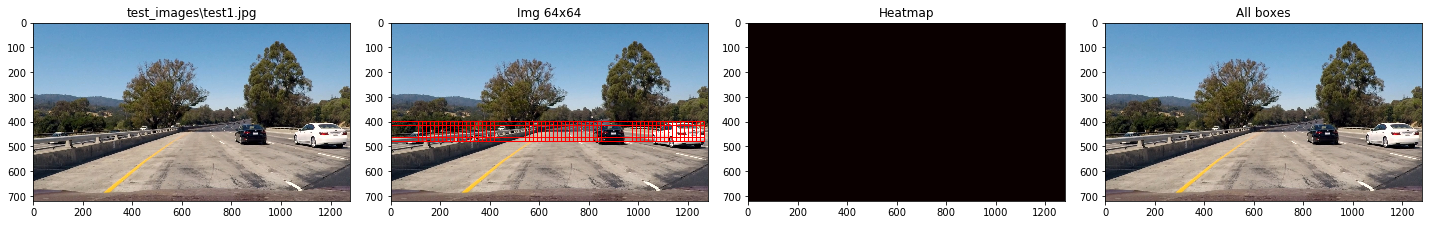

In [37]:
#test_video_images = glob.glob('test_video_images/*.jpg')
#test_video_images.sort(key=os.path.getmtime)

test_images = glob.glob('test_images/*.jpg')

for img_name in test_images[0:1]:
    img = mpimg.imread(img_name)
    process_image(img, plot=True, convert=False)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output = 'test_video_processed.mp4'
clip = VideoFileClip("test_video.mp4")
output_clip = clip.fl_image(process_image) 
%time output_clip.write_videofile(output, audio=False)

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
project_output = 'project_video_processed.mp4'
project_clip = VideoFileClip("project_video.mp4")
project_output_clip = project_clip.fl_image(process_image) 
%time project_output_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))